In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import seaborn as sns
import random
import pathlib

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/dataset-original.zip" -d "/content/drive/MyDrive"

In [3]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [4]:
base_dir = '/content/drive/MyDrive/trash_dataset'
dataset = pathlib.Path(base_dir)
print(str(dataset))

/content/drive/MyDrive/trash_dataset


In [5]:
train_dir = str(dataset) + '/train'
test_dir = str(dataset) + '/test'
data_train = pathlib.Path(train_dir)
data_test = pathlib.Path(test_dir)

print(str(data_train))
print(str(data_test))

/content/drive/MyDrive/trash_dataset/train
/content/drive/MyDrive/trash_dataset/test


In [6]:
class_names = np.array(tf.io.gfile.listdir(str(data_train)))
class_names = class_names[class_names != '.DS_Store']
print(class_names)

['paper' 'metal' 'plastic' 'glass' 'trash' 'cardboard']


In [7]:
batch_size = 32
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.
Using 2160 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.
Using 540 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)


In [12]:
def get_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  return img

In [13]:
def get_img_and_label(file_path):
  label = get_label(file_path)
  img = get_image(file_path)
  return img, label

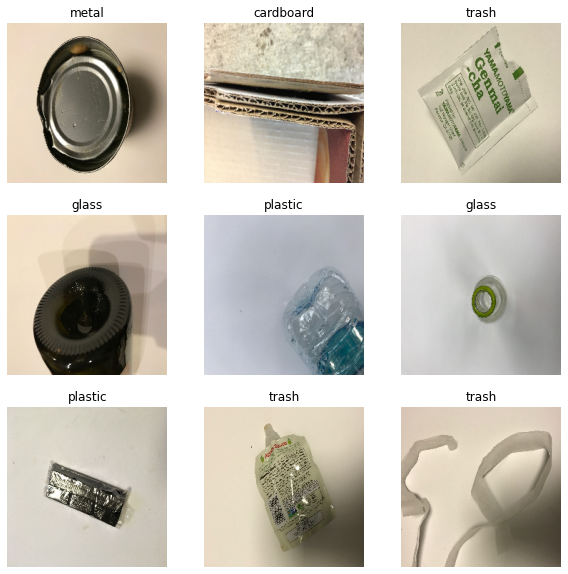

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1)
  ]
)

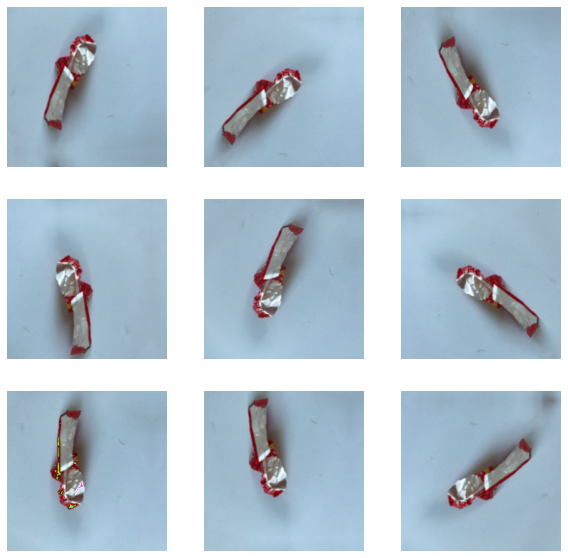

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
def pre_process(image_files):
  files_ds = tf.data.Dataset.from_tensor_slices(image_files)
  image_ds = files_ds.map(map_func=get_img_and_label, num_parallel_calls=AUTOTUNE)
  return image_ds

In [16]:
num_classes = len(class_names)
print(num_classes)

6


In [ ]:
with strategy.scope():
  inputs = layers.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = tf.keras.applications.vgg16.preprocess_input(x, data_format=None)
  outputs = VGG16(include_top=True, weights=None, classes=num_classes, 
                  classifier_activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 6)                 134285126 
                                                                 
Total params: 134,285,126
Trainable params: 134,285,126
Non

In [ ]:
epochs = 100
hist = model.fit(train_ds, 
                 epochs=epochs, 
                 validation_data=val_ds)

Epoch 1/100
68/68 [==============================] - 65s 891ms/step - loss: 34.2113 - accuracy: 0.1662 - val_loss: 1.7852 - val_accuracy: 0.1944
Epoch 2/100
68/68 [==============================] - 59s 870ms/step - loss: 1.7898 - accuracy: 0.1722 - val_loss: 1.7896 - val_accuracy: 0.1759
Epoch 3/100
68/68 [==============================] - 59s 865ms/step - loss: 1.7802 - accuracy: 0.1991 - val_loss: 1.7316 - val_accuracy: 0.2426
Epoch 4/100
68/68 [==============================] - 59s 868ms/step - loss: 1.7525 - accuracy: 0.2532 - val_loss: 1.8088 - val_accuracy: 0.1722
Epoch 5/100
68/68 [==============================] - 59s 869ms/step - loss: 1.7560 - accuracy: 0.2292 - val_loss: 1.7548 - val_accuracy: 0.2296
Epoch 6/100
68/68 [==============================] - 59s 869ms/step - loss: 1.6473 - accuracy: 0.3236 - val_loss: 1.5256 - val_accuracy: 0.4259
Epoch 7/100
68/68 [==============================] - 59s 867ms/step - loss: 1.5230 - accuracy: 0.3625 - val_loss: 1.5004 - val_accuracy

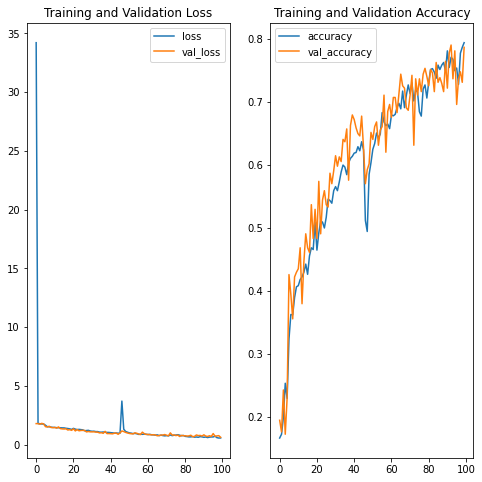

In [ ]:
metrics = hist.history
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(hist.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.show()

In [17]:
test_files = filenames = tf.io.gfile.glob(str(data_test) + '/*/*.jpg')
test_ds = pre_process(test_files)

In [18]:
test_images = []
test_labels = []

for image, label in test_ds:
  test_images.append(image.numpy())
  test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [19]:
model_VGG = tf.keras.models.load_model('/content/drive/MyDrive/VGG16.h5')

In [ ]:
loss, acc = model_VGG.evaluate(test_images, test_labels)
print('Restored model, accuracy: {:5.0f}%'.format(100 * acc))

20/20 [==============================] - 37s 814ms/step - loss: 0.9852 - accuracy: 0.6825
Restored model, accuracy:    68%


In [20]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model_VGG.predict(test_images), axis=1)
y_true = test_labels

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.85      0.75      0.80       101
       glass       0.64      0.58      0.61       125
       metal       0.60      0.70      0.65       102
       paper       0.75      0.76      0.76       148
     plastic       0.68      0.57      0.62       120
       trash       0.48      0.85      0.62        34

    accuracy                           0.68       630
   macro avg       0.67      0.70      0.68       630
weighted avg       0.70      0.68      0.68       630



In [27]:
import sklearn.metrics as skm

cm = skm.multilabel_confusion_matrix(y_true, y_pred)
print(cm)

[[[516  13]
  [ 25  76]]

 [[465  40]
  [ 53  72]]

 [[481  47]
  [ 31  71]]

 [[445  37]
  [ 35 113]]

 [[478  32]
  [ 51  69]]

 [[565  31]
  [  5  29]]]


In [ ]:
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 68%


In [ ]:
model.save('/content/drive/MyDrive/VGG16.h5')

In [ ]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'model.h5')
tfmodel = converter.convert()
open ("model.tflite" , "wb") .write(tfmodel)

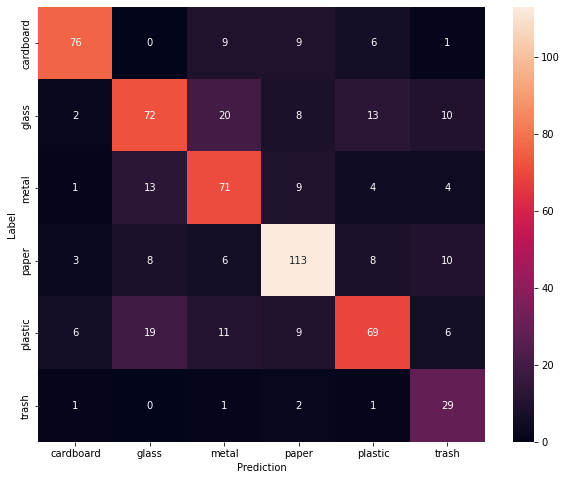

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()